In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import torch

In [32]:
data = pd.read_csv("input/GS_South_Pars.csv")

In [33]:
# Separate features (first 11 columns) and target
X = data.iloc[:, :11].values  # First 11 columns as features
y = data['MAMINE(MOL/HR)'].values.reshape(-1, 1)  # Target variable, reshaped to 2D

In [34]:
# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [35]:
# Confirming the split ratios
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (12738, 11), Validation set: (4246, 11), Test set: (4246, 11)


In [36]:
# Scale features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

In [37]:
# Scale target using MinMaxScaler (or StandardScaler for more normalized distribution)
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val = scaler_y.transform(y_val.reshape(-1, 1))
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [38]:
# Initialize the TabNet model33333333333 with a balanced configuration
model3 = TabNetRegressor(
    n_d=32,  # Feature embeddings
    n_a=32,  # Attention embeddings
    n_steps=5,  # Number of decision steps
    gamma=1.5,  # Feature reusage penalty
    n_independent=2,  # Independent FC layers
    n_shared=2,  # Shared FC layers
    lambda_sparse=1e-3,  # Sparsity regularization
    optimizer_fn=torch.optim.AdamW,
    optimizer_params=dict(lr=1e-2, weight_decay=1e-5),
    mask_type='entmax',  # Sparsemax for feature selection
    scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
    scheduler_params={"max_lr": 0.03, 
                      "steps_per_epoch": X_train.shape[0] // 32,
                      "epochs": 300,
                      "pct_start": 0.3, "anneal_strategy": "cos", "div_factor": 10}
)

c:\Users\mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [39]:
# Train the model with validation monitoring
model3.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_name=['val'],
    eval_metric=['rmse'],
    max_epochs=300,
    patience=20,  # Early stopping if no improvement
    batch_size=15,
    virtual_batch_size=32,
    num_workers=0,
    drop_last=False
)

epoch 0  | loss: 0.14095 | val_rmse: 0.13119 |  0:00:31s
epoch 1  | loss: 0.02045 | val_rmse: 0.09794 |  0:00:58s
epoch 2  | loss: 0.01359 | val_rmse: 0.09997 |  0:01:24s
epoch 3  | loss: 0.01103 | val_rmse: 0.0633  |  0:01:51s
epoch 4  | loss: 0.00921 | val_rmse: 0.05247 |  0:02:20s
epoch 5  | loss: 0.00707 | val_rmse: 0.05911 |  0:02:48s
epoch 6  | loss: 0.00732 | val_rmse: 0.04712 |  0:03:16s
epoch 7  | loss: 0.00687 | val_rmse: 0.06342 |  0:03:47s
epoch 8  | loss: 0.00647 | val_rmse: 0.04362 |  0:04:16s
epoch 9  | loss: 0.00635 | val_rmse: 0.0476  |  0:04:44s
epoch 10 | loss: 0.00574 | val_rmse: 0.06355 |  0:05:11s
epoch 11 | loss: 0.00492 | val_rmse: 0.03992 |  0:05:37s
epoch 12 | loss: 0.00545 | val_rmse: 0.04096 |  0:06:05s
epoch 13 | loss: 0.00521 | val_rmse: 0.04385 |  0:06:36s
epoch 14 | loss: 0.00455 | val_rmse: 0.0546  |  0:07:03s
epoch 15 | loss: 0.00436 | val_rmse: 0.03433 |  0:07:31s
epoch 16 | loss: 0.0044  | val_rmse: 0.05007 |  0:07:59s
epoch 17 | loss: 0.00347 | val_

c:\Users\mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [40]:
# Predict and rescale on the test set
y_pred_scaled = model3.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Inverse transform to original scale
y_test_original = scaler_y.inverse_transform(y_test)  # Original scale for comparison

In [41]:
# Evaluate performance with MSE and R²
import numpy as np

mse = mean_squared_error(y_test_original, y_pred)
r2 = r2_score(y_test_original, y_pred)
rmse = np.sqrt(mse)
print(f'Mean Squared Error on Test Set: {mse}')
print(f'R² Score on Test Set: {r2}')
print(f'RMSE for MH2O(MOL/HR): {rmse}')

Mean Squared Error on Test Set: 0.030042709866452865
R² Score on Test Set: 0.9877110408524006
RMSE for MH2O(MOL/HR): 0.17332832967075193


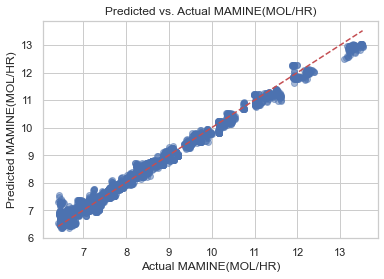

In [42]:
import matplotlib.pyplot as plt

plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.xlabel("Actual MAMINE(MOL/HR)")
plt.ylabel("Predicted MAMINE(MOL/HR)")
plt.title("Predicted vs. Actual MAMINE(MOL/HR)")
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'r--')
plt.show()

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [44]:
# Set plot style for a professional look
sns.set(style="whitegrid", palette="muted")

C:\Users\mostafa\AppData\Local\Temp\ipykernel_13992\3583232692.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc)


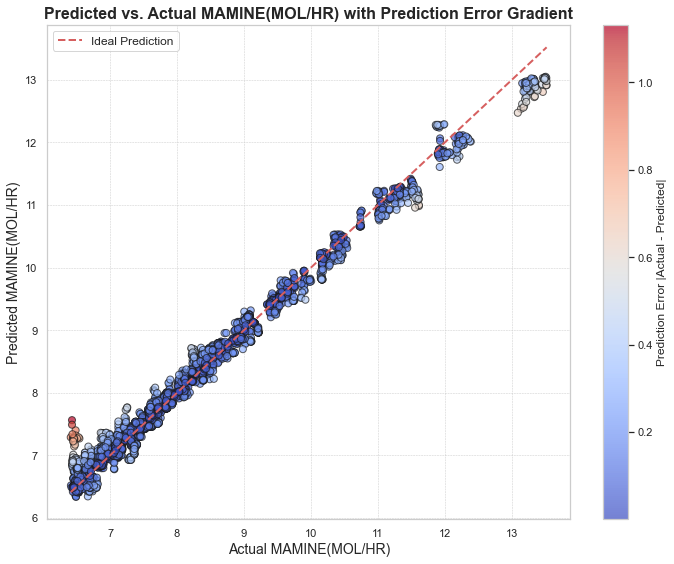

In [45]:
# Set plot style for a professional look
sns.set(style="whitegrid", palette="muted")

# Set figure size and create a scatter plot with color gradient
plt.figure(figsize=(10, 8))
sc = plt.scatter(
    y_test_original, y_pred, 
    c=np.abs(y_pred - y_test_original), 
    cmap="coolwarm", s=50, alpha=0.7, edgecolor="k"
)

# Add color bar to indicate prediction error (absolute difference)
cbar = plt.colorbar(sc)
cbar.set_label("Prediction Error |Actual - Predicted|", fontsize=12)

# Plot a 1:1 line for reference
plt.plot(
    [y_test_original.min(), y_test_original.max()], 
    [y_test_original.min(), y_test_original.max()], 
    'r--', lw=2, label="Ideal Prediction"
)

# Set axis labels and title with enhanced font size
plt.xlabel("Actual MAMINE(MOL/HR)", fontsize=14)
plt.ylabel("Predicted MAMINE(MOL/HR)", fontsize=14)
plt.title("Predicted vs. Actual MAMINE(MOL/HR) with Prediction Error Gradient", fontsize=16, fontweight='bold')

# Customize legend and plot aesthetics
plt.legend(loc="upper left", fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)

# Show plot
plt.tight_layout()
plt.show()

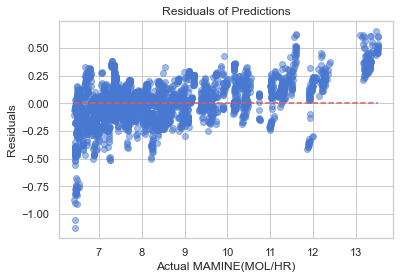

In [46]:
residuals = y_test_original - y_pred
plt.scatter(y_test_original, residuals, alpha=0.5)
plt.hlines(0, y_test_original.min(), y_test_original.max(), colors='r', linestyles='dashed')
plt.xlabel("Actual MAMINE(MOL/HR)")
plt.ylabel("Residuals")
plt.title("Residuals of Predictions")
plt.show()

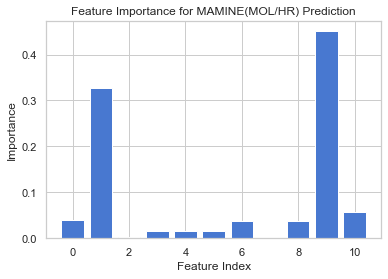

In [47]:
feature_importances = model.feature_importances_
plt.bar(range(len(feature_importances)), feature_importances)
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.title("Feature Importance for MAMINE(MOL/HR) Prediction")
plt.show()

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [49]:
# Example feature names (replace with actual feature names if available)
feature_names = ["CO2(in)", "H2S(in)","N2(in)","C1(in)","C2(in)","C3(in)","IC4(in)","HEX-T-HOT-C","REG-COL-MOLE-RR","GASIN-MASSFLOW-(KG/HR)","VALVE-P-OUT-(BAR)"]

In [50]:
# Feature importances from the model
feature_importances = model3.feature_importances_

In [51]:
# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

In [52]:
# Sort by importance for a more informative visualization
importance_df = importance_df.sort_values(by="Importance", ascending=True)

In [53]:
# Set up a larger, more readable figure size
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")


<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

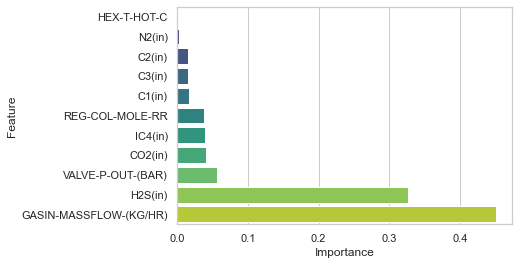

In [54]:
# Horizontal bar plot
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

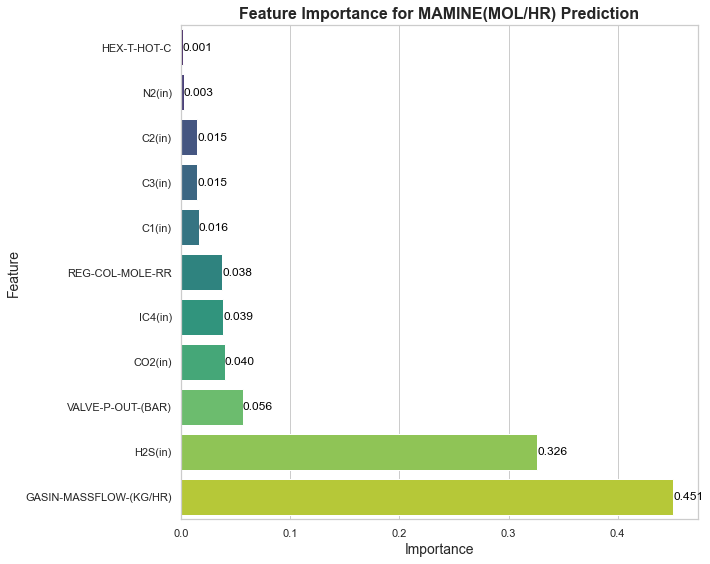

In [55]:


# Create a DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance for a more informative visualization
importance_df = importance_df.sort_values(by="Importance", ascending=True)

# Set up a larger, more readable figure size
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Horizontal bar plot
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")

# Add title and labels
plt.title("Feature Importance for MAMINE(MOL/HR) Prediction", fontsize=16, fontweight='bold')
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)

# Add data labels to each bar for clarity
for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.3f}', color='black', ha="left", va="center")

plt.tight_layout()
plt.show()